In [1]:
from pathlib import Path

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from layouts import Layout
from layouts.library import surface_code
from layouts.util.transmons import set_freq_groups, set_target_freqs, sample_freqs, sample_params, any_collisions, get_num_collisions

/Users/boris/.pyenv/versions/3.8.2/lib/python3.8/site-packages/qutip/__init__.py:59: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.16.
  warnings.warn(


In [2]:
NOTEBOOK_DIR = Path.cwd()

DATA_FOLDER = NOTEBOOK_DIR / "data"
DATA_FOLDER.mkdir(parents=True, exist_ok=True)

In [11]:
DISTANCE = 3

GROUP_FREQS = np.array([5.00, 5.07, 5.14, 5.21, 5.28]) # Following IBM definitions
GROUP_ANHARMS = np.repeat(-0.33, len(GROUP_FREQS))

layout = surface_code(DISTANCE, mixed_layout=False)
set_freq_groups(layout)
set_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)

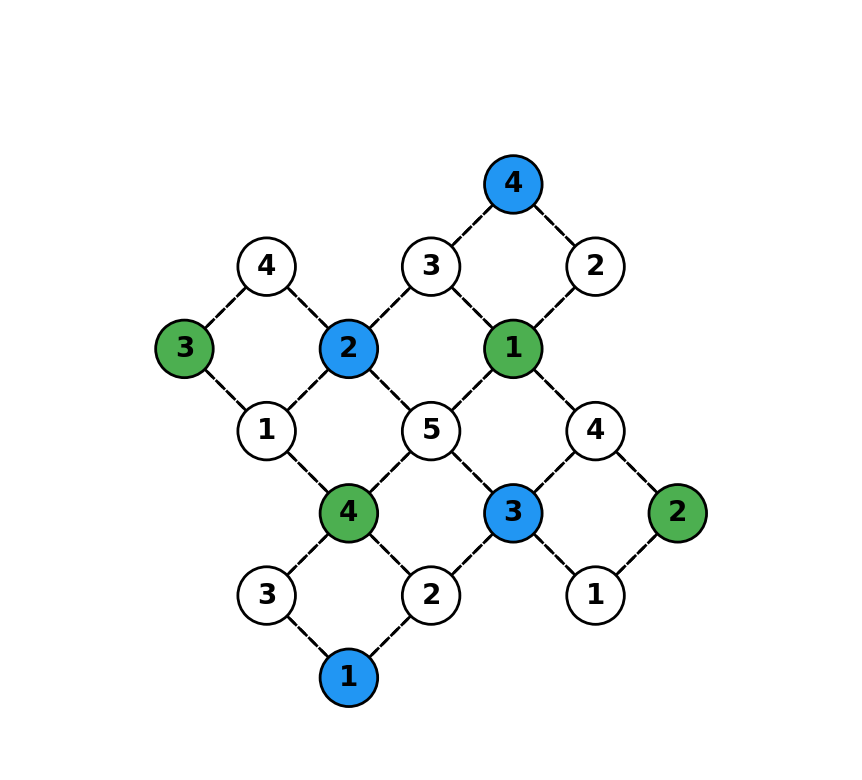

In [12]:
fig, ax = plt.subplots(dpi=200)

layout.plot(param_label="freq_group", axis=ax)
plt.tight_layout()
plt.show()

# Scan for distance 3

In [13]:
MIN_FREQ_VAR = 0.004
MAX_FREQ_VAR = 0.060
NUM_FREQ_VARS = 22
NUM_SEEDS = 4000

FREQ_VARS = np.geomspace(MIN_FREQ_VAR, MAX_FREQ_VAR, NUM_FREQ_VARS)
SEEDS = np.arange(1, NUM_SEEDS + 1)

BOUNDS = [0.017, 0.030, 0.004, 0.017, 0.025, 0.017]

collisions = np.zeros((NUM_FREQ_VARS, NUM_SEEDS), dtype=int)

for var_ind, freq_var in enumerate(FREQ_VARS):
    for seed_ind, seed in enumerate(SEEDS):
        sample_freqs(layout, seed, freq_var)
        if not any_collisions(layout, BOUNDS):
            collisions[var_ind, seed_ind] = 1

In [14]:
device_yield = np.mean(collisions, axis= 1)

With the spectator collision enabled

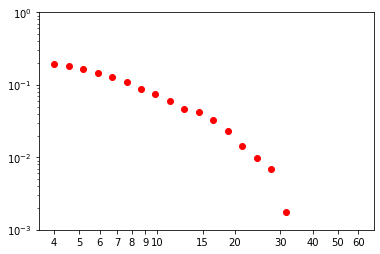

In [15]:
fig, ax = plt.subplots()

#qubit_target_freq_vars = [layout.param("target_freq", q) * FREQ_VARS * 1e3 for q in layout.get_qubits()]
#mean_freq_vars = np.mean(qubit_target_freq_vars, axis=0)

#ax.scatter(mean_freq_vars, device_yield, color="red")
ax.scatter(FREQ_VARS*1e3, device_yield, color="red")
ax.set_xscale("log")

ax.set_yscale("log")

#ax.set_xticks([10, 20, 30, 40, 50, 60, 70, 80, 80, 90, 100])
ax.set_xticks([4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 60])
#ax.set_xticklabels(["10", "20", "30", "40", "50", "60", "70", "80", "80", "90", "100"])
ax.set_xticklabels(["4", "5", "6", "7", "8", "9", "10", "15", "20", "30", "40", "50", "60"])


ax.set_ylim(1e-3, 1)
plt.show()

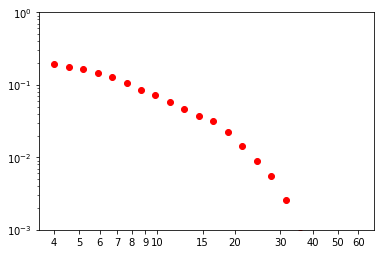

In [60]:
fig, ax = plt.subplots()

#qubit_target_freq_vars = [layout.param("target_freq", q) * FREQ_VARS * 1e3 for q in layout.get_qubits()]
#mean_freq_vars = np.mean(qubit_target_freq_vars, axis=0)

#ax.scatter(mean_freq_vars, device_yield, color="red")
ax.scatter(FREQ_VARS*1e3, device_yield, color="red")
ax.set_xscale("log")

ax.set_yscale("log")

#ax.set_xticks([10, 20, 30, 40, 50, 60, 70, 80, 80, 90, 100])
ax.set_xticks([4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 60])
#ax.set_xticklabels(["10", "20", "30", "40", "50", "60", "70", "80", "80", "90", "100"])
ax.set_xticklabels(["4", "5", "6", "7", "8", "9", "10", "15", "20", "30", "40", "50", "60"])


ax.set_ylim(1e-3, 1)
plt.show()

# Scan with distance as well

In [20]:
MIN_FREQ_VAR = 0.004
MAX_FREQ_VAR = 0.060
NUM_FREQ_VARS = 22
NUM_SEEDS = 4000

DISTANCES = [3, 5, 7]
FREQ_VARS = np.geomspace(MIN_FREQ_VAR, MAX_FREQ_VAR, NUM_FREQ_VARS)
SEEDS = np.arange(1, NUM_SEEDS + 1)

BOUNDS = [0.017, 0.030, 0.004, 0.017, 0.025, 0.007]

collisions = np.zeros((len(DISTANCES), NUM_FREQ_VARS, NUM_SEEDS), dtype=int)

for dist_ind, distance in enumerate(DISTANCES):
    layout = surface_code(distance, mixed_layout=False)
    
    set_freq_groups(layout)
    set_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)

    for var_ind, freq_var in enumerate(FREQ_VARS):
        for seed_ind, seed in enumerate(SEEDS):
            sample_freqs(layout, seed, freq_var, relative_var=False)
            if not any_collisions(layout, BOUNDS):
                collisions[dist_ind, var_ind, seed_ind] = 1

In [21]:
collision_arr = xr.DataArray(
    collisions,
    dims = ["distance", "freq_var", "seed"],
    coords = dict(
        distance = DISTANCES,
        freq_var = FREQ_VARS,
        seed = SEEDS
    )
)

In [65]:
LOAD_DATA=False

if LOAD_DATA:
    DISTANCES = [3, 5, 7]
    MAX_FREQ_VAR = 1e-2
    NUM_SEEDS = 50000
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)

    data_arr_name = f"tmon_tmob_yield_scan_dist_{*DISTANCES,}_max_var_{MAX_FREQ_VAR}_seeds_{NUM_SEEDS}.nc"
    collisions = xr.load_dataarray(data_folder/data_arr_name)

In [22]:
#total_collisions = collisions.sum(dim="collision_type")
#collision_stats = collisions.sum(dim="seed")

#zero_collision_runs = xr.where(total_collisions == 0, 1, 0)
device_yield = collision_arr.mean(dim="seed")

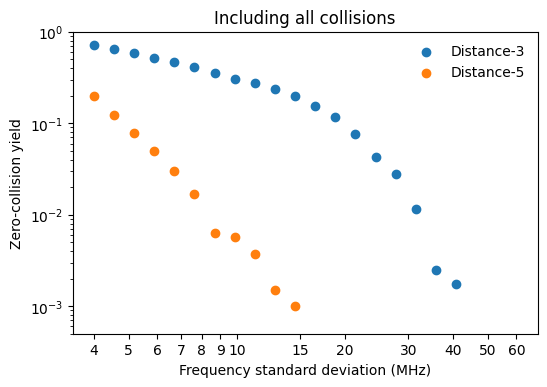

In [25]:
fig, ax = plt.subplots(dpi=100)

for dist in device_yield.distance.values:
    if dist != 7:
        label = f"Distance-{dist}"
        ax.scatter(
            device_yield.freq_var * 1e3, 
            device_yield.sel(distance=dist),
            label=label,
        )
    
ax.set_xscale("log")
ax.set_xlabel(r"Frequency standard deviation (MHz)")
ax.set_ylabel(r"Zero-collision yield")
ax.set_yscale("log")
ax.set_ylim(5e-4, 1)
ax.set_xticks([4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 60])
#ax.set_xticklabels(["10", "20", "30", "40", "50", "60", "70", "80", "80", "90", "100"])
ax.set_xticklabels(["4", "5", "6", "7", "8", "9", "10", "15", "20", "30", "40", "50", "60"])
ax.legend(frameon=False)
ax.set_title("Including all collisions")

plt.savefig(
    "transmon_lattce_yield_vs_freq_dev_scan.pdf",  
    dpi=300,  
    bbox_inches='tight', 
    transparent=True, 
    format="pdf",
)

plt.show()

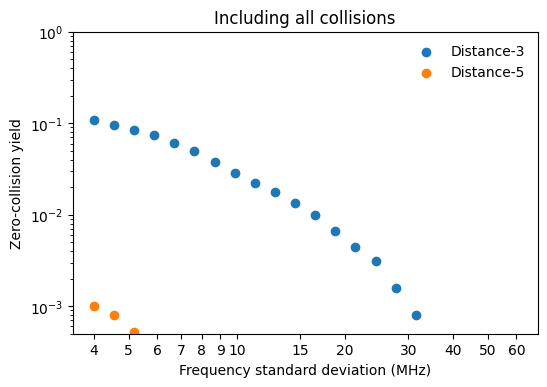

In [69]:
fig, ax = plt.subplots(dpi=100)

for dist in device_yield.distance.values:
    if dist != 7:
        label = f"Distance-{dist}"
        ax.scatter(
            device_yield.freq_var * 1e3, 
            device_yield.sel(distance=dist),
            label=label,
        )
    
ax.set_xscale("log")
ax.set_xlabel(r"Frequency standard deviation (MHz)")
ax.set_ylabel(r"Zero-collision yield")
ax.set_yscale("log")
ax.set_ylim(5e-4, 1)
ax.set_xticks([4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 60])
#ax.set_xticklabels(["10", "20", "30", "40", "50", "60", "70", "80", "80", "90", "100"])
ax.set_xticklabels(["4", "5", "6", "7", "8", "9", "10", "15", "20", "30", "40", "50", "60"])
ax.legend(frameon=False)
ax.set_title("Including all collisions")

plt.savefig(
    "transmon_lattce_yield_vs_freq_dev_scan.pdf",  
    dpi=300,  
    bbox_inches='tight', 
    transparent=True, 
    format="pdf",
)

plt.show()

In [42]:
MIN_FREQ_VAR = 0.004
MAX_FREQ_VAR = 0.060
NUM_FREQ_VARS = 22
NUM_SEEDS = 20000

DISTANCES = [3, 5, 7]
FREQ_VARS = np.geomspace(MIN_FREQ_VAR, MAX_FREQ_VAR, NUM_FREQ_VARS)
SEEDS = np.arange(1, NUM_SEEDS + 1)

BOUNDS = [0.017, 0.030, 0.004, 0.017, 0.025, 0]

collisions = np.zeros((len(DISTANCES), NUM_FREQ_VARS, NUM_SEEDS), dtype=int)

for dist_ind, distance in enumerate(DISTANCES):
    layout = surface_code(distance, mixed_layout=False)
    
    set_freq_groups(layout)
    set_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)

    for var_ind, freq_var in enumerate(FREQ_VARS):
        for seed_ind, seed in enumerate(SEEDS):
            sample_freqs(layout, seed, freq_var, relative_var=False)
            if not any_collisions(layout, BOUNDS):
                collisions[dist_ind, var_ind, seed_ind] = 1

In [43]:
other_collision_arr = xr.DataArray(
    collisions,
    dims = ["distance", "freq_var", "seed"],
    coords = dict(
        distance = DISTANCES,
        freq_var = FREQ_VARS,
        seed = SEEDS
    )
)
other_device_yield = other_collision_arr.mean(dim="seed")

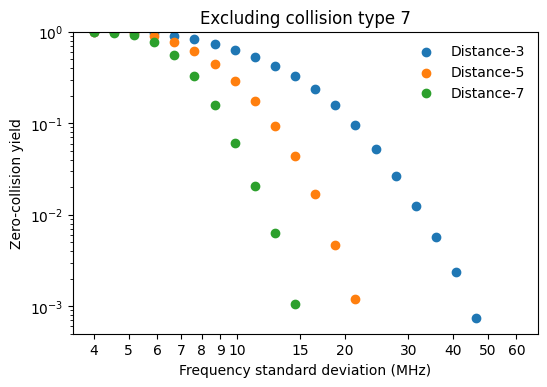

In [68]:
fig, ax = plt.subplots(dpi=100)

for dist in other_device_yield.distance.values:
    label = f"Distance-{dist}"
    ax.scatter(
        other_device_yield.freq_var * 1e3, 
        other_device_yield.sel(distance=dist),
        label=label,
    )
    
ax.set_xscale("log")
ax.set_xlabel(r"Frequency standard deviation (MHz)")
ax.set_ylabel(r"Zero-collision yield")
ax.set_yscale("log")
ax.set_ylim(5e-4, 1)
ax.set_xticks([4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 60])
#ax.set_xticklabels(["10", "20", "30", "40", "50", "60", "70", "80", "80", "90", "100"])
ax.set_xticklabels(["4", "5", "6", "7", "8", "9", "10", "15", "20", "30", "40", "50", "60"])
ax.legend(frameon=False)

ax.set_title("Excluding collision type 7")

plt.savefig(
    "transmon_lattce_yield_vs_freq_dev_scan_cond_7_excluded.pdf",  
    dpi=300,  
    bbox_inches='tight', 
    transparent=True, 
    format="pdf",
)

plt.show()

# Scan with distance and as function of resistance variance

In [4]:
MIN_RES_VAR = 1e-3
MAX_RES_VAR = 1e-1
NUM_RES_VARS = 20
NUM_SEEDS = 10000

GROUP_FREQS = np.array([5.00, 5.07, 5.14, 5.21, 5.28]) # Following IBM definitions
GROUP_ANHARMS = np.repeat(-0.33, len(GROUP_FREQS))

DISTANCES = [3, 5, 7]
RES_VARS = np.geomspace(MIN_RES_VAR, MAX_RES_VAR, NUM_RES_VARS)
SEEDS = np.arange(1, NUM_SEEDS + 1)

BOUNDS = [0.017, 0.030, 0.004, 0.017, 0.025, 0.017]

for dist_ind, distance in enumerate(DISTANCES):
    result = np.zeros((NUM_RES_VARS, NUM_SEEDS), dtype=int)
    
    layout = surface_code(distance, mixed_layout=False)
    set_freq_groups(layout)
    set_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)

    for var_ind, res_var in enumerate(RES_VARS):
        for seed_ind, seed in enumerate(SEEDS):
            sample_params(layout, seed, res_var)
            if not any_collisions(layout, BOUNDS):
                result[var_ind, seed_ind] = 1
                
    collision_arr = xr.DataArray(
        result,
        dims = ["resist_var", "seed"],
        coords = dict(
            distance = distance,
            resist_var = RES_VARS,
            seed = SEEDS
        )
    )
    
    data_arr_name = f"transmon_device_yield_d_{distance}_resist_{MIN_RES_VAR}_{MAX_RES_VAR}_seeds_{NUM_SEEDS}_v2.nc"
    collision_arr.to_netcdf(DATA_FOLDER/data_arr_name)

In [5]:
collision_arrays = []
    
for distance in [3, 5, 7]:
    da_name = f"transmon_device_yield_d_{distance}_resist_{MIN_RES_VAR}_{MAX_RES_VAR}_seeds_{NUM_SEEDS}_v2.nc"
    array = xr.load_dataarray(DATA_FOLDER/da_name)
    collision_arrays.append(array)
    
full_collision_arr = xr.concat(collision_arrays, dim="distance")

In [6]:
device_yield = full_collision_arr.mean(dim="seed")

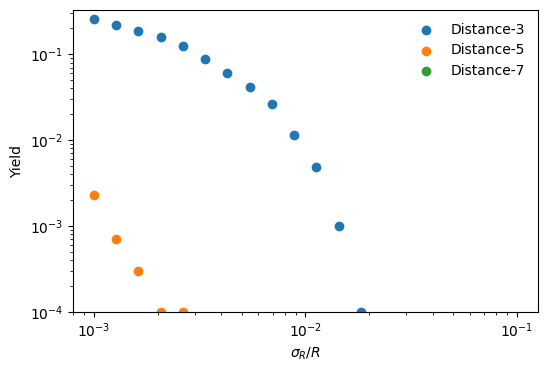

In [7]:
fig, ax = plt.subplots(dpi=100)

for dist in device_yield.distance.values:
    label = f"Distance-{dist}"
    ax.scatter(
        device_yield.resist_var, 
        device_yield.sel(distance=dist),
        label=label,
    )
    
ax.set_xscale("log")
ax.set_xlabel(r"$\sigma_{R}/R$")
ax.set_ylabel(r"Yield")
ax.set_yscale("log")
ax.set_ylim(1e-4)
#ax.set_xlim(1e-3, 1e-1)
ax.legend(frameon=False)

plt.show()

In [8]:
MIN_RES_VAR = 1e-3
MAX_RES_VAR = 1e-1
NUM_RES_VARS = 20
NUM_SEEDS = 10000

GROUP_FREQS = np.array([5.00, 5.07, 5.14, 5.21, 5.28]) # Following IBM definitions
GROUP_ANHARMS = np.repeat(-0.33, len(GROUP_FREQS))

DISTANCES = [3, 5, 7]
RES_VARS = np.geomspace(MIN_RES_VAR, MAX_RES_VAR, NUM_RES_VARS)
SEEDS = np.arange(1, NUM_SEEDS + 1)

BOUNDS = [0.017, 0.030, 0.004, 0.017, 0.025, 0]

for dist_ind, distance in enumerate(DISTANCES):
    result = np.zeros((NUM_RES_VARS, NUM_SEEDS), dtype=int)
    
    layout = surface_code(distance, mixed_layout=False)
    set_freq_groups(layout)
    set_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)

    for var_ind, res_var in enumerate(RES_VARS):
        for seed_ind, seed in enumerate(SEEDS):
            sample_params(layout, seed, res_var)
            if not any_collisions(layout, BOUNDS):
                result[var_ind, seed_ind] = 1
                
    collision_arr = xr.DataArray(
        result,
        dims = ["resist_var", "seed"],
        coords = dict(
            distance = distance,
            resist_var = RES_VARS,
            seed = SEEDS
        )
    )
    
    data_arr_name = f"transmon_device_yield_d_{distance}_resist_{MIN_RES_VAR}_{MAX_RES_VAR}_seeds_{NUM_SEEDS}_v2_collision_7_disabled.nc"
    collision_arr.to_netcdf(DATA_FOLDER/data_arr_name)

In [9]:
collision_arrays = []
    
for distance in [3, 5, 7]:
    da_name = f"transmon_device_yield_d_{distance}_resist_{MIN_RES_VAR}_{MAX_RES_VAR}_seeds_{NUM_SEEDS}_v2_collision_7_disabled.nc"
    array = xr.load_dataarray(DATA_FOLDER/da_name)
    collision_arrays.append(array)
    
full_collision_arr = xr.concat(collision_arrays, dim="distance")

In [10]:
device_yield = full_collision_arr.mean(dim="seed")

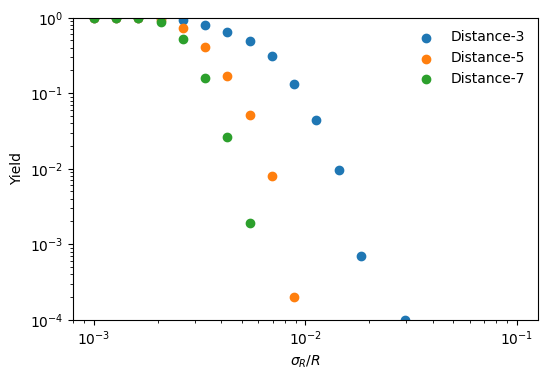

In [11]:
fig, ax = plt.subplots(dpi=100)

for dist in device_yield.distance.values:
    label = f"Distance-{dist}"
    ax.scatter(
        device_yield.resist_var, 
        device_yield.sel(distance=dist),
        label=label,
    )
    
ax.set_xscale("log")
ax.set_xlabel(r"$\sigma_{R}/R$")
ax.set_ylabel(r"Yield")
ax.set_yscale("log")
ax.set_ylim(1e-4)
#ax.set_xlim(1e-3, 1e-1)
ax.legend(frameon=False)

plt.show()

OLD STUFF

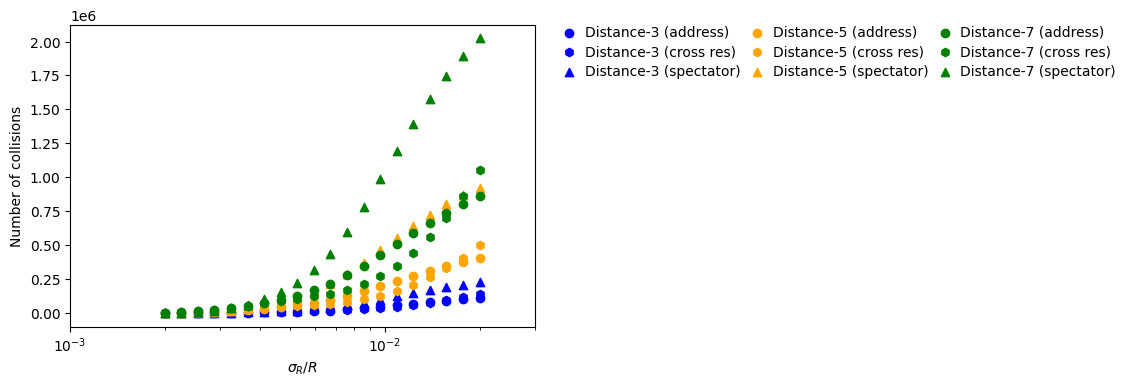

In [17]:
fig, ax = plt.subplots(dpi=100)

markers = dict(
    address = "o",
    cross_res = "h",
    spectator = "^"
)

colors = dict(dist_3 = "blue", dist_5 = "orange", dist_7 = "green")

for dist in collision_stats.distance.values:
    color = colors[f"dist_{dist}"]
    for col_type in collision_stats.collision_type.values:
        
        col_label = "cross res" if col_type == "cross_res" else col_type
        label = f"Distance-{dist} ({col_label})"
        ax.scatter(
            collision_stats.freq_var * 2, 
            collision_stats.sel(distance=dist, collision_type=col_type),
            label=label,
            color=color,
            marker = markers[col_type]
        )
    
ax.set_xscale("log")
ax.set_xlabel(r"$\sigma_{R}/R$")
ax.set_ylabel(r"Number of collisions")
ax.set_xlim(1e-3, 3e-2)
ax.legend(
    frameon=False, 
    ncol=3,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handletextpad=0.4,
    labelspacing=0.4,
    borderpad=0,
    markerscale=1.0,
    handlelength=1.5,
    borderaxespad=0.05,
    columnspacing=0.4
)

plt.show()

In [177]:
SAVE_DATA = True

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    data_arr_name = f"tmon_tmob_yield_scan_dist_{*DISTANCES,}_max_var_{MAX_FREQ_VAR}_seeds_{NUM_SEEDS}.nc"
    collisions.to_netcdf(data_folder/data_arr_name)

# Misc

In [96]:

import math

delta_f = 27.99
sigma_f = 4

a =  delta_f / 
integral = np.sqrt(np.pi/2)*(math.erf(a/np.sqrt(2)) + 1)
num_qubits = 17

print(integral**num_qubits)

289.5096488665332


In [124]:
NUM_SEEDS = 20000
BOUNDS = [0.017, 0.030, 0.004, 0.017, 0.025, 0.006]
SEEDS = np.arange(1, NUM_SEEDS + 1)

layout = surface_code(5, mixed_layout=False)
set_freq_groups(layout)
set_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)

res = np.zeros(NUM_SEEDS, dtype=int)
for seed_ind, seed in enumerate(SEEDS):
    sample_freqs(layout, seed, 0.01, relative_var=False)
    if not any_collisions(layout, BOUNDS):
        res[seed_ind] = 1

In [3]:
layout = surface_code(3, mixed_layout=False)

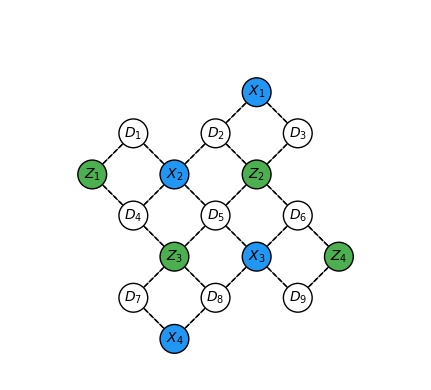

In [4]:
fig, ax = plt.subplots(dpi=100)

layout.plot(axis=ax)
plt.tight_layout()
plt.show()

In [26]:
from typing import Optional

def set_freq_groups(layout: Layout, init_qubit: Optional[str] = None, init_group: Optional[int] = 0) -> None:
    num_groups = 5
    group_assign_order = ["north_west", "north_east", "south_west", "south_east"]

    qubits = layout.get_qubits()
    if init_qubit is None:
        init_qubit = qubits.pop()
    else:
        if init_qubit not in qubits:
            raise ValueError("Provided init_qubit is not in the layout qubits.")

    assigned_qubits = set()

    def dfs_assign(qubit, freq_group):
        if qubit not in assigned_qubits:
            layout.set_param("freq_group", qubit, freq_group + 1)
            assigned_qubits.add(qubit)

            neighbors_dict = layout.param("neighbors", qubit)
            for direction, neighbour in neighbors_dict.items():
                if (
                    neighbour
                ):  # Supports more explicit syntax where absent neighbours are set as none
                    group_shift = group_assign_order.index(direction) + 1
                    neighbor_freq_group = (freq_group + group_shift) % num_groups
                    dfs_assign(neighbour, neighbor_freq_group)

    dfs_assign(init_qubit, init_group)

In [27]:
set_freq_groups(layout, init_qubit="D2")

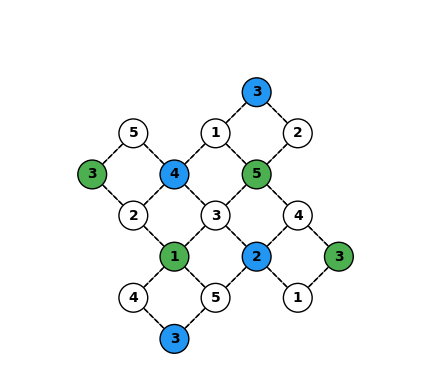

In [28]:
fig, ax = plt.subplots(dpi=100)

layout.plot(param_label="freq_group", axis=ax)
plt.tight_layout()
plt.show()

In [29]:
GROUP_FREQS = np.array([5.00, 5.07, 5.14, 5.21, 5.28]) # Following IBM definitions
GROUP_ANHARMS = np.repeat(-0.33, len(GROUP_FREQS))

set_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)

In [32]:
NUM_SEEDS = 20000
BOUNDS = [0.017, 0.030, 0.004, 0.017, 0.025, 0.017]
SEEDS = np.arange(1, NUM_SEEDS + 1)
FREQ_VAR = 0.004

res = np.zeros(NUM_SEEDS, dtype=int)
for seed_ind, seed in enumerate(SEEDS):
    sample_freqs(layout, seed, FREQ_VAR, relative_var=False)
    if not any_collisions(layout, BOUNDS):
        res[seed_ind] = 1

In [33]:
np.mean(res)

0.193